In [36]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from window import HanningWindow, KBDWindow, SineWindow
from psychoac import SPL, Thresh

In [37]:
def get_x(N, Fs):
    n_array = np.arange(N)
    x = (
        0.40 * np.cos(2 * np.pi * 220 * n_array / Fs)
        + 0.24 * np.cos(2 * np.pi * 330 * n_array / Fs)
        + 0.18 * np.cos(2 * np.pi * 440 * n_array / Fs)
        + 0.08 * np.cos(2 * np.pi * 880 * n_array / Fs)
        + 0.04 * np.cos(2 * np.pi * 4400 * n_array / Fs)
        + 0.02 * np.cos(2 * np.pi * 8800 * n_array / Fs)
    )
    return x

noise floor i
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2]
1161.0
noise floor ii
-8.02569024296066
[13. 16. 14. 15. 15. 12. 11. 14.  8.  3.  1.  1.  1.  1.  0.  0.  0. 10.
 12.  0.  0. 11.  0.  0.  0.]
[13 16 14 15 15 12 11 14  8  3  2  2  2  0  0  0  0 10 12  0  0 11  0  0
  0]
1152
noise floor iii
-50.18616206943989
[10. 11.  8.  9. 10.  8.  8. 10.  5.  2.  3.  4.  6.  7.  8.  6.  1.  8.
 10.  0.  0. 10.  0.  0.  0.]
[10 11  8  9 10  8  8 10  5  1  3  4  6  7  8  6  1  8 10  0  0 10  0  0
  0]
1160


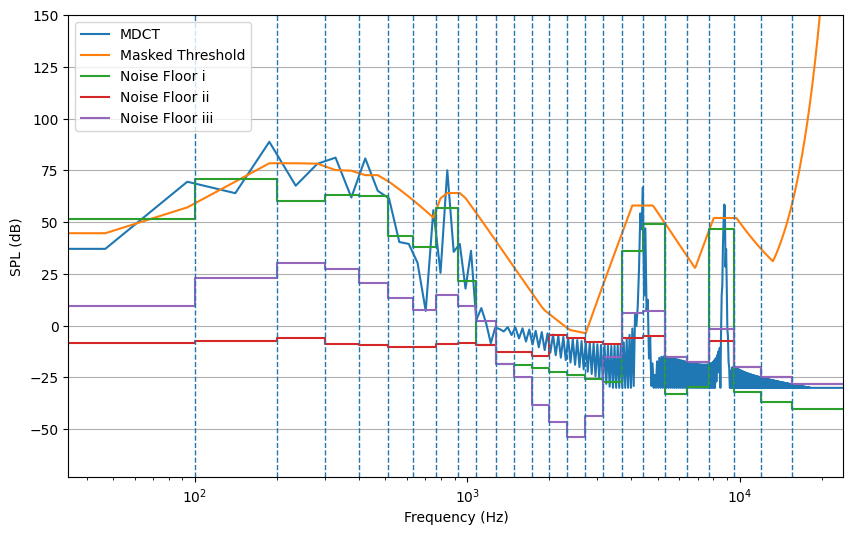

In [ ]:
# 1.c)
from mdct import MDCT
from psychoac import (
    AssignMDCTLinesFromFreqLimits,
    ScaleFactorBands,
    getMaskedThreshold,
    intensity_from_DFT,
    intensity_from_MDCT,
    CalcSMRs,
    cbFreqLimits,
)
from quantize import ScaleFactor

N = 1024
nMDCTLines = N // 2
sampleRate = 48000
data = get_x(N, sampleRate)
nLines = AssignMDCTLinesFromFreqLimits(nMDCTLines, sampleRate)
# print(nLines.cumsum())
sfBands = ScaleFactorBands(nLines)

# MDCT: use KBDWindow
data_windowed = KBDWindow(data)
MDCTdata = MDCT(data_windowed, nMDCTLines, nMDCTLines)

# calculate masked threshold etc.
masked_thresh = getMaskedThreshold(data, None, None, sampleRate, sfBands)
freq_array = np.arange(N // 2) / N * sampleRate
quiet_thresh = Thresh(freq_array)
DFTspl = SPL(intensity_from_DFT(scipy.fft.rfft(HanningWindow(data))[:-1]))
MDCTspl = SPL(intensity_from_MDCT(MDCTdata))
MDCTspl_sfb = np.array(
    [
        np.max(MDCTspl[sfBands.lowerLine[i] : sfBands.upperLine[i] + 1])
        for i in range(sfBands.nBands)
    ]
)

sfb_array = np.concat(([0], cbFreqLimits, [24000]))

# hard-coded bit allocation array
# uniform
print("noise floor i")
mt_uniform = np.concat((np.ones(20) * 3, np.ones(5) * 2))
nf_uniform = np.array(MDCTspl_sfb)
nf_uniform[:20] -= 18
nf_uniform[20:] -= 12
print(mt_uniform.astype(int))
print(np.sum(mt_uniform * sfBands.nLines))

# constant noise floor
print("noise floor ii")
target_area = 6966
lo = np.min(MDCTspl_sfb)
hi = np.max(MDCTspl_sfb)

tol = 1e-6  # tolerance for stopping
while hi - lo > tol:
    mid = (lo + hi) / 2
    # Compute the area: sum up (SPL - mid) wherever SPL is above mid.
    area = np.sum(np.maximum(MDCTspl_sfb - mid, 0) * sfBands.nLines)
    if area > target_area:
        lo = mid
    else:
        hi = mid

nf_const_c = (lo + hi) / 2
print(nf_const_c)
mt_const = np.maximum((MDCTspl_sfb - nf_const_c) / 6, 0)
# print(mt_const)
mt_const = np.round(mt_const, decimals=0)
print(mt_const)
mt_const = np.array([13, 16, 14, 15, 15, 12, 11, 14,  8,  3,  2,  2,  2,  0,  0,  0,  0, 10, 12,  0,  0, 11,  0,  0,  0])  # fmt:off
print(mt_const)
print(np.sum(mt_const * sfBands.nLines))
nf_const = MDCTspl_sfb - mt_const * 6

# constant distance below the masked threshold curve
print("noise floor iii")
masked_thresh_sfb = np.array(
    [
        np.average(masked_thresh[sfBands.lowerLine[i] : sfBands.upperLine[i] + 1])
        for i in range(sfBands.nBands)
    ]
)
target_area = 6966
lo = -200
hi = 200

tol = 1e-6  # tolerance for stopping
while hi - lo > tol:
    mid = (lo + hi) / 2  # this is the distance from the masked threshold
    nf = masked_thresh_sfb + mid  # an array of subbands
    # Compute the area: sum up (SPL - mid) wherever SPL is above mid.
    area = np.sum(np.maximum(MDCTspl_sfb - nf, 0) * sfBands.nLines)
    if area > target_area:
        lo = mid
    else:
        hi = mid

mid = (lo + hi) / 2
print(mid)
nf_nmr = masked_thresh_sfb + mid
mt_nmr = (MDCTspl_sfb - nf_nmr) / 6
mt_nmr = np.maximum(mt_nmr, 0)
mt_nmr = np.round(mt_nmr, decimals=0)
print(mt_nmr)
mt_nmr = np.array([10, 11,  8,  9, 10,  8,  8, 10,  5,  2,  3,  4,  6,  7,  8,  6,  0,  8, 10,  0,  0, 10,  0,  0,  0])  # fmt:off
print(mt_nmr)
print(np.sum(mt_nmr * sfBands.nLines))
nf_nmr = MDCTspl_sfb - mt_nmr * 6


# plot
def extended(x):
    # for step plotting, prepend the first value
    return np.insert(x, 0, x[0])


plt.figure(figsize=(10, 6))
# plt.plot(freq_array, DFTspl, label="DFT Signal")
plt.plot(freq_array, MDCTspl, label="MDCT")
# plt.plot(freq_array, quiet_thresh, label="Threshold in quiet")
# plt.step(sfb_array, extended(MDCTspl_sfb), label="MDCT Peaks")
plt.plot(freq_array, masked_thresh, label="Masked Threshold")
plt.step(sfb_array, extended(nf_uniform), label="Noise Floor i")
plt.step(sfb_array, extended(nf_const), label="Noise Floor ii")
# plt.step(sfb_array, extended(masked_thresh_sfb), label="Masked Threshold (avg)")
plt.step(sfb_array, extended(nf_nmr), label="Noise Floor iii")
for f in cbFreqLimits:
    plt.axvline(f, linestyle="--", linewidth=1)
plt.xscale("log")
plt.xlim(right=24000)
plt.ylim(top=150)
plt.xlabel("Frequency (Hz)")
plt.ylabel("SPL (dB)")

plt.grid(axis="y")
plt.legend()
plt.show()

MDCT_maxMagnitude = np.max(np.abs(MDCTdata))
MDCTscale = ScaleFactor(MDCT_maxMagnitude)
MDCTdata = MDCTdata * (2**MDCTscale)
SMRs = CalcSMRs(data, MDCTdata, MDCTscale, sampleRate, sfBands)
# print(np.around(SMRs, decimals=3))
